# Advanced Machine Learning - programming assignment 1

*Due: Friday December 1st*

**Please fill in:**
* Panagiotis Aronis (9398333)
* Martino Fabiani (2257742)

### Further instructions:
* Code quality is considered during the assessment. Make sure your code is properly commented. 
* Submit your code in Blackboard using **one** of your accounts; we will put the grade in Blackboard for the other team member as well.
* Make sure to name the submitted file according to your and your collaborators last name (i.e. submitter_collaborator.ipynb). 
* **Failure to follow these instructions can affect the assignment grade.**

## Multi-armed Bandits

In this programming assignment, we will look at how we can solve a k-armed bandit problem as discussed in the lecture. Expect for winning at the slot machines, you are expect to better understand the tradeoff between exploration and exploitation. 

Here are the objectives of this assignment:
1.   Get familier with the Open-AI gym/gymnasium environment,
2.   Implement your own k-armed bandit environment based on the gym framework,
3.   Use an epsilon-greedy algorithm to find the optimal action for this k-armed bandit problem,
4.   Play with the parameter epsilon and identify a reasonable setting for balancing exploration and exploitation. 
    

### 0. Please check the given 'README' file

### 1. Let's start with the OpenAI gym

Gym/Gymnasium (https://gymnasium.farama.org/) is a wide-used toolkit for developing and comparing reinforcement learning algorithms. 

1. Gym/Gymnasium makes no assumptions about the structure of your agent, and is compatible with any numerical computation library, such as TensorFlow or Theano. 

2. The library is a collection of test problems — **environments** — that you can use to work out your reinforcement learning algorithms. These environments have a shared interface, allowing you to write general algorithms.

**Great!** Now let's import the gym class and work on a basic example of gym code.


In [1]:
import gymnasium

Like mentioned above, gym's main purpose is to provide a large collection of **environments** that expose a common interface. You can find a listing of those environments below (they are Markov decision process(MDP) environments and we will discuss MDP in our lecture 11), as follows:

In [2]:
from gymnasium import envs
print(envs.registry)

{'CartPole-v0': EnvSpec(id='CartPole-v0', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=195.0, nondeterministic=False, max_episode_steps=200, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=0, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'CartPole-v1': EnvSpec(id='CartPole-v1', entry_point='gymnasium.envs.classic_control.cartpole:CartPoleEnv', reward_threshold=475.0, nondeterministic=False, max_episode_steps=500, order_enforce=True, autoreset=False, disable_env_checker=False, apply_api_compatibility=False, kwargs={}, namespace=None, name='CartPole', version=1, additional_wrappers=(), vector_entry_point='gymnasium.envs.classic_control.cartpole:CartPoleVectorEnv'), 'MountainCar-v0': EnvSpec(id='MountainCar-v0', entry_point='gymnasium.envs.classic_control.mountain_car:MountainCarEnv', reward_thr

We are now going to explain how the RL framework of gym works. 
- An **ENVIRONMENT**, 
- You also have an **AGENT**,
- The agent takes an **ACTION**, in our case, 10 actions are possible to take,
- When a single **ACTION** is chosen and fed to our **ENVIRONMENT**, the **ENVIRONMENT** measures how good the action was taken and produces a **REWARD**, which is usually a numeric value.

In MDP problems, the **ENVIRONMENT** will also provides an **OBSERVATION**, which represets the state of the **ENVIRONMENT** at the current moment. In the multi-armed bandit problems, there is no **OBSERVATION** (or state). You may understand this better after the lecture about Markov decision process (MDP). 

Please read the 'Basic usage' https://gymnasium.farama.org/content/basic_usage/ for better understanding the framework. 


### 2. Implement your own environment

Next, we are going to implement our own environment following the framework of gym. This enviroment is a gambiling room with ten different slot machines (a 10-armed bandit problem). Similar with examples given in the lecture, the reward of each slot machine follows a normal distribution, but the average reward (mean) and variance of each action are different. Your goal is to determine the optimal action from all possible actions/machines. 

The core gym interface is **Env**, which is the unified environment interface. There is no interface for agents. The following are the Env methods you should know:

- `step(self, action)`: Steps the environment by one timestep. Returns observation, reward, done, info.
- `reset(self)`: Resets the environment to an initial state. Returns an initial observation. Each call of `reset()` should yield an environment suitable for a new episode, independent of previous episodes. Because there is no state transition in multi-armed bandit problems, this function is not used here.
- `render(self, mode='human')`: Renders one frame of the environment. The default mode will do something human friendly, such as pop up a window. In this assignment, there is no need to create a pop up window. 

Before writing your own codes, read through the readme of github page of gymasium (https://github.com/Farama-Foundation/Gymnasium). You are also recommended to read at least the codes for one simple environment and one example agent.

#### 2.1 Self-defined Slot Machine

**Please fill in the missing codes in the function sample (1 point).**

In [3]:
import numpy as np

class SlotMachine:
    """
        A slot machine contains a reward distribution that is randomly generated with restricted mean and standard deviation. 
            sample function: generates a reward at each time step based on the given reward distribution
    """
    def __init__(self):
        self.mu = np.random.uniform(-5, 5)  # mean
        self.sigma = np.random.uniform(0.5, 1)  # standard deviation

    def sample(self):
        # draw a random reward based on the machine's normal distribution N(mu, sigma)
        reward = np.random.normal(loc=self.mu, scale=self.sigma)
        return reward


#### 2.2 Game Environment
**Please fill in the missing codes in function step (1 point) in the environment.** 

In [4]:
from gymnasium import spaces

# The environment has to inherit the interface of gymnasium.Env
class GamblingRoom(gymnasium.Env):
    """
        A k-armed bandit environment: a gambling room with slot machines, allows the agents to interact with it.
            r_machines: A list of slot machines, each gamblingRoom contains k number of slotMachines
    """
    def __init__(self, k, seed=None):
        self.seed(seed)
        # initialize reward distribution for each action/machine
        self.r_machines = []
        for i in range(k):
            # each gamblingRoom contains k number of slotMachines
            self.r_machines.append(SlotMachine())

        self.num_arms = k
        self.action_space = spaces.Discrete(self.num_arms)
        self.observation_space = spaces.Discrete(1)
        # for our bandit environment, the state is constant
        self.state = 0

    # step up the environment based on the selected action,
    # return the constant state, reward, done = false, and info 
    # for now, we do not have to worry about the DONE and INFO variables.
    def step(self, action):
        assert self.action_space.contains(action)
        done = False

        # get a reward from the slot machine corresponding to the agent's action
        machine = self.r_machines[action]
        reward = machine.sample()

        return self.state, reward, done, {}

    # random seed used for reproducibility purposes
    def seed(self, seed):
        if seed is not None:
            np.random.seed(seed)

    def reset(self):
        pass

    def render(self, mode='human', close=False):
        pass

    def close(self):
        pass


### 3. Implement an agent with the epsilon greedy algorithm

In this part, you are expected to implement an RL agent. To decide the action to take at each time step, this agent uses the epsilon greedy algorithm introduced in the lecture.

**Please fill in the missing codes in function select_action (1.5 points) and update_parameters (1 point) in the agent.** Feel free to import the needed packages if there are any.

In [5]:
class EpsilonGreedyAgent:
    """
        An agent that can interact with the environment, implementing an epsilon greedy
        strategy, attempting to maximize expected rewards in the long run.
    """
    def __init__(self, k, e):
        # set up the number of arms/actions
        self.num_arms = k
        # set up the value of epsilon
        self.epsilon = e
        # init the estimated values of all actions
        self.Qvalues = np.zeros(k)
        # init the numbers of time step that every action is selected
        self.stepSize = np.zeros(k)

    ##
    # select the action to take at the current time step
    # (for MDP, choose the action based on state; for k-armed bandit, no state given)
    # return: the action to take
    ##
    def select_action(self):
        # draw a random number from uniform [0,1) to decide between exploration / exploitation
        number = np.random.rand()

        if number < self.epsilon:
            # exploration case with probability epsilon
            # choose a random action with equal probability
            action = np.random.choice(self.num_arms)
        else:
            # exploitation case with probability 1-epsilon
            # choose a greedy action (max Qvalue) based on current estimates
            # (ties are broken randomly)
            maxQvalue = self.Qvalues.max()
            greedy_actions = np.where(self.Qvalues == maxQvalue)[0]
            action = np.random.choice(greedy_actions)

        return action

    ##
    # Update the Q-values of the agent based on received rewards
    # input: action_index = the action, reward = the reward from this action
    # return: null
    ##
    def update_parameters(self, action, reward):
        # increment the times we have chosen the action by one
        self.stepSize[action] += 1
        # incremental update of the action's estimated value towards the reward
        self.Qvalues[action] += (reward - self.Qvalues[action]) / self.stepSize[action]


### 4. Run the simulation, play with parameters and analyse results

Finally, we write codes for running the simulation. 

In order to decrease the effect of randomness, we usually conduct multiple simulation runs and average the results. In the implementation, you may start with one run, then use the variable `num_runs` for running multiple simulations.

In each run, you shall setup the `epsilon` and number of time step `num_episodes` (0.01 and 500 by default). Then, after the initialization of our agent and environment, **please fill in the missing codes (with ??? or TODO: to be filled). (2.5 points)**

Discrete(10)
Slot Machine 0: Rewards ~ N(μ = -1.25, σ = 0.98)
Slot Machine 1: Rewards ~ N(μ = 2.32, σ = 0.80)
Slot Machine 2: Rewards ~ N(μ = -3.44, σ = 0.58)
Slot Machine 3: Rewards ~ N(μ = -4.42, σ = 0.93)
Slot Machine 4: Rewards ~ N(μ = 1.01, σ = 0.85)
Slot Machine 5: Rewards ~ N(μ = -4.79, σ = 0.98)
Slot Machine 6: Rewards ~ N(μ = 3.32, σ = 0.61)
Slot Machine 7: Rewards ~ N(μ = -3.18, σ = 0.59)
Slot Machine 8: Rewards ~ N(μ = -1.96, σ = 0.76)
Slot Machine 9: Rewards ~ N(μ = -0.68, σ = 0.65)


0it [00:00, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

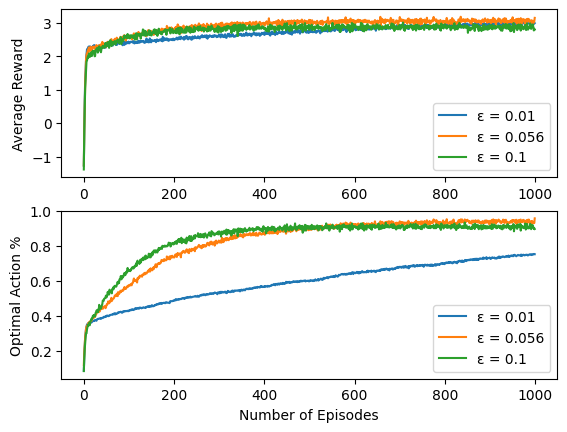

In [6]:
num_actions = 10  # number of slot machines / actions
num_seed = 42  # environment with random seed 42
num_runs = 1000  # number of simulation runs
num_episodes = 1000  # number of steps in each run

# test one epsilon greedy agent for eache value
epsilons = [0.01, 0.056, 0.1]

# init the environment and set up the random seed
# new environment with num_actions slot machines and random seed = num_seed
env = GamblingRoom(k=num_actions, seed=num_seed)

# delete the wrap
env = env.unwrapped

# show the action space
print(env.action_space)
for i, machine in enumerate(env.r_machines):
    print(f'Slot Machine {i}: Rewards ~ N(μ = {machine.mu:.2f}, σ = {machine.sigma:.2f})')

# the reward achieved per agent per run per time step
rewards_results = np.zeros((len(epsilons), num_runs, num_episodes))
# the action selected per agent per run per time step
actions_results = np.zeros((len(epsilons), num_runs, num_episodes))

# progress bars
from tqdm.notebook import tqdm

# compare different epsilon greedy agents
for i_agent, epsilon in tqdm(enumerate(epsilons)):
    # run multiple simulations
    for i_run in tqdm(range(num_runs)):

        # init the epsilon-greedy RL agent 
        agent = EpsilonGreedyAgent(k=num_actions, e=epsilon)
        # in each simulation run, loop the action selection
        for i_episode in range(num_episodes):

            # agent action selection
            action = agent.select_action()
            # environment observations (everything except the reward is explicitly ignored)
            _state, reward, _done, _info = env.step(action)
            # agent value estimations update
            agent.update_parameters(action, reward)

            # save the result variables you need
            # the reward achieved by this agent in this run in this time step
            rewards_results[i_agent][i_run][i_episode] = reward
            # the action selected by this agent in this run in this time step
            actions_results[i_agent][i_run][i_episode] = action

env.close()

# compute average rewards per timestep
average_rewards = np.mean(rewards_results, axis=1)

# compute optimal action selection percentage per timestep
optimal_action = np.argmax([machine.mu for machine in env.r_machines])
is_optimal = lambda action: action == optimal_action
actions_results = is_optimal(actions_results)
optimal_actions = np.mean(actions_results, axis=1)


import matplotlib.pyplot as plt

# plot average rewards per timestep
plt.subplot(2, 1, 1)
plt.ylabel('Average Reward')
for i_agent, epsilon in enumerate(epsilons):
    plt.plot(average_rewards[i_agent], label=f'ε = {epsilon}')

#plt.xlabel('Number of Episodes')
plt.legend()

# plot optimal action selection percentage per timestep
plt.subplot(2, 1, 2)
plt.ylabel('Optimal Action %')
for i_agent, epsilon in enumerate(epsilons):
    plt.plot(optimal_actions[i_agent], label=f'ε = {epsilon}')

plt.xlabel('Number of Episodes')
plt.legend()


Now it's time to examine the performance of algorithms with different epsilon values (different exploration strategies) in multiple simulation runs. 

You shall play with the parameter epsilon under 2 or 3 different gambling environments (by initlizing different reward distributions for machines). **For each environment, try at least 2 different values of epsilon and identify a reasonable epsilon value that could balance the exploration and exploitation**. Instead of handing in your codes for this part, please select one environment you have tested and describe your environment and experimental settings **(1 point)**. Then, provide an explanation on how you identify the good epsilon value in this environment and why it is a good one **(1 point)**. 

Few instructions:
- Your answer shall include two plots presenting comparable measures of the different epsilon settings (e.g. the average reward per step and % of optimal action). **(1 point)** 
- You shall present the average results from at least 100 simulation runs. Remember that the gambling environment CANNOT be changed over those runs used for calculating the average results. 
- You may adjust the total time steps when the learning needs more time for a cerain epsilon value, but do not over spend your time on this.    

**Put your answer (at most 300 words) with accompanying plots here.** 

The chosen environment for our experimental analysis is generated with random seed 42. There are 10 slot machines and their rewards follow different (unknown) normal distributions. Each one of the three epsilon greedy agents we tested (epsilon values: 0.1, 0.056, 0.01) can choose between these 10 actions on each time step (episode). We simulated the agent-environment interactions for a total of 1000 episodes and we averaged the results over 1000 independent runs in the same environment.

The plots, generated by the code above, display for each epsilon greedy agent the average rewards per episode and the percentage of optimal action selection, that is, the seventh action in our case with expected reward of 3.3. The same plots extended to 5000 episodes are also provided, but they are not generated as they are more computationally intensive.

It is evident that the 'best' epsilon value depends on the amount of time we allow epsilon greedy agents to converge with respect to the mentioned measures. In order to find a reasonable value of epsilon for this particular instance of 10-armed bandit problem, we tested the performance of multiple agents after 500 episodes, essentially handling the original continuous task as episodic. In particular, we found that the average reward after 500 episodes is maximized by the epsilon greedy agent with epsilon set to 0.056. This value achieves the correct balance between exploration and exploitation for the specified episodic task.

The provided plots support our expectations that agents with greater epsilon values learn the optimal action faster because they explore more, but their asymptotic performance is worse as they continue to explore with the same probability (provided epsilon is constant) even after they found the optimal action. Conversely, setting epsilon to smaller values (greater than zero) lead to a slower convergence but with higher value.


You are almost done! Before handing in, make sure that the codes you hand in work, and that all plots are shown. **Submit just one file per team.** Please make sure that you submit a .zip file with images.

Again, make sure you name this file according to your last names.